In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_confidence_ellipse(mu, cov, alph, ax, clabel=None, label_bg='white', **kwargs):
    """Display a confidence ellipse of a bivariate normal distribution
    
    Arguments:
        mu {array-like of shape (2,)} -- mean of the distribution
        cov {array-like of shape(2,2)} -- covariance matrix
        alph {float btw 0 and 1} -- level of confidence
        ax {plt.Axes} -- axes on which to display the ellipse
        clabel {str} -- label to add to ellipse (default: {None})
        label_bg {str} -- background of clabel's textbox
        kwargs -- other arguments given to class Ellipse
    """
    c = -2 * np.log(1 - alph)  # quantile at alpha of the chi_squarred distr. with df = 2
    Lambda, Q = la.eig(cov)  # eigenvalues and eigenvectors (col. by col.)
    
    ## Compute the attributes of the ellipse
    width, heigth = 2 * np.sqrt(c * Lambda)
    # compute the value of the angle theta (in degree)
    theta = 180 * np.arctan(Q[1,0] / Q[0,0]) / np.pi if cov[1,0] else 0
        
    ## Create the ellipse
    if 'fc' not in kwargs.keys():
        kwargs['fc'] = 'None'
    level_line = Ellipse(mu, width, heigth, angle=theta, **kwargs)
    
    ## Display a label 'clabel' on the ellipse
    if clabel:
        col = kwargs['ec'] if 'ec' in kwargs.keys() and kwargs['ec'] != 'None' else 'black'  # color of the text
        pos = Q[:,1] * np.sqrt(c * Lambda[1]) + mu  # position along the heigth
        
        ax.text(*pos, clabel, color=col,
           rotation=theta, ha='center', va='center', rotation_mode='anchor', # rotation
           bbox=dict(boxstyle='round',ec='None',fc=label_bg, alpha=1)) # white box
        
    return ax.add_patch(level_line)

In [2]:
from sklearn.cluster import KMeans
from cupyx.scipy.special import digamma, gammaln
import time
from scipy.stats import multivariate_normal
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt
import cupy as cp
def log_wishart_B(invW, nu):
    D = len(invW)
    return + 0.5 * nu * cp.log(cp.linalg.det(invW)) \
           - 0.5 * nu * D * cp.log(2) \
           - 0.25 * D * (D-1) * cp.log(cp.pi) \
           - gammaln(0.5 * (nu - cp.arange(D))).sum()

class VariationalGaussianMixture():
    """Variarional Bayesian estimation of a Gaussian mixture

    References
    ----------
        [1] Corduneanu, Adrian and Bishop, Christopher M. (2001), "Variational 
        Bayesian Model Selection for Mixture Distributions", in Proc. AI and 
        Statistics Conf., pp. 27-34."""

    def __init__(self, K, init_param="kmeans", seed=2208, max_iter=200, 
                 beta0=None, nu0=None, invW0=None):
        self.beta0 = beta0
        self.nu0 = nu0
        self.invW0 = invW0
        self.K=K
        self.init_param = init_param
        self.rd = cp.random.RandomState(seed)
        self.max_iter = max_iter
    def _initialize(self, X):
        n_samples, D = X.shape
        self.nu0 = self.nu0 or D
        self.invW0 = self.invW0 or cp.atleast_2d(cp.cov(X.T))
        self.beta0 = self.beta0 or 1.

        self.weights = cp.ones(self.K) / self.K
      
        kmeans = KMeans(n_clusters=self.K, random_state=0).fit(X)
        MU_=cp.asarray(kmeans.cluster_centers_)
        ## Init expectations
        expect = {"T" : cp.array([self.nu0 * cp.linalg.inv(self.invW0) for _ in range(self.K)]),#[K,D,D]
                  "log_det_T" : cp.zeros(self.K),
                  "mu" :MU_ ,  # (23)np.zeros((self.K, D))
                  "mu_muT" :cp.array([cp.outer(MU_[i],MU_[i]) for i in range(self.K)]) }##np.zeros((self.K, D, D))
        
        
        if self.init_param == "random":
            resp = self.rd.rand(n_samples, self.K)
            resp /= resp.sum(axis=1).reshape(-1,1)
        
        elif self.init_param == "kmeans":
            resp = cp.zeros((n_samples, self.K))
            label = KMeans(n_clusters=self.K, n_init=1).fit(X).labels_
            resp[cp.arange(n_samples), label] = 1

      
        
        else:
            raise ValueError("Correct values for 'init_param' are ['random', 'kmeans']")
   
        self._update_params(X, resp, expect)

    def _compute_expectations(self, D):
        exp_T = self.nu.reshape(-1,1,1) * cp.linalg.inv(self.invW)  # (25)
        exp_log_det_T = cp.sum(digamma(0.5 * (self.nu - cp.arange(D).reshape(-1,1))), axis=0) \
            + D * cp.log(2) - cp.log(cp.linalg.det(self.invW))  # (26)

        expect = {"T" : exp_T,
                  "log_det_T" : exp_log_det_T,
                  "mu" : cp.copy(self.m),  # (23)
                  "mu_muT" : cp.zeros_like(self.S),
                  "muT_mu": cp.zeros(self.K)}
        
        invS = cp.linalg.inv(self.S)
        for k in range(self.K):
            expect["mu_muT"][k] = cp.add(invS[k],cp.outer(self.m[k], self.m[k]))  # (24)
            expect["muT_mu"][k] = cp.add(cp.trace(invS[k]),cp.matmul(self.m[k],self.m[k]))
        return expect
    def compute_rho(self,X, expect):
        N, D = X.shape
        X=cp.asarray(X)
        log_rho_tilde = cp.zeros((N,self.K))
        #print(cp.sum(cp.multiply(cp.matmul(X,expect["T"][1]),X),1).shape)
        #print(cp.matmul(X,cp.matmul(expect["T"][1],expect["mu"][1])).shape)
        for k in range(self.K):
            log_rho_tilde[:, k] =0.5 * expect["log_det_T"][k]- 0.5 * (cp.sum(cp.multiply(cp.matmul(X,expect["T"][k]),X),1)-2*cp.matmul(X,cp.matmul(expect["T"][k],expect["mu"][k]))+cp.trace(cp.matmul(expect["T"][k],expect["mu_muT"][k])))
        
        log_rho=log_rho_tilde + cp.log(self.weights +1e-12).reshape(1,-1) 
        rho=cp.exp(log_rho)+1e-24
        resp =cp.divide(rho,cp.sum(rho,1).reshape(-1,1))  # (16)
       
        return resp, log_rho_tilde
       
    def _update_params(self, X, resp, expect):
        N, D = X.shape
        X=cp.asarray(X)
        eta = resp.sum(axis=0) # sum_n (z_nk)
        self.nu = self.nu0 + eta  # (20)
        #print(1)
        self.S = cp.add((self.beta0 * cp.eye(D)),cp.multiply(expect["T"],eta.reshape(-1,1,1))) # (18)
        #print(2)
        invS = cp.linalg.inv(self.S)
        
        self.invW = cp.zeros((self.K, D, D))  # init (21)
        self.m = cp.zeros((self.K, D))  # init (19)
        #print(type(X))
        for k in range(self.K):
            self.m[k] = cp.matmul(cp.matmul(invS[k],expect["T"][k]),cp.matmul(resp[:, k],X))  # (19)

            
            
            s = cp.subtract(cp.matmul(X.T,cp.multiply(resp[:,k].reshape(-1,1),X)),cp.outer(cp.matmul(resp[:,k],X),expect["mu"][k])) \
                    +cp.subtract(eta[k]*expect["mu_muT"][k],cp.outer(expect["mu"][k],cp.matmul(resp[:,k],X)))  # (21 --)
            self.invW[k] = cp.add(self.invW0,s)  # (-- 21)

    def _m_step(self, resp):
        self.weights = resp.sum(axis=0) / resp.sum()
    def _get_final_parameters(self):
        #print(self.nu.shape)
        self.covs = cp.divide(self.invW,self.nu.reshape(-1,1,1))
    def _compute_lower_bound(self, X, resp, log_rho_tilde, expect):
        N, D = X.shape
        X=cp.asarray(X)
        ln_p_x = cp.sum(cp.multiply(resp,(log_rho_tilde)))  # (28)
        ln_p_z = cp.sum(cp.multiply(resp,cp.log(self.weights).reshape(1,-1)))  # (29)
        #print(7)
        ln_p_mu = self.K * D * cp.log(0.5 * self.beta0 / cp.pi) \
            - 0.5 * self.beta0 * cp.sum(expect["muT_mu"])  # (30)
        #print(8)
        ln_p_T = self.K * log_wishart_B(self.invW0, self.nu0) \
            + 0.5 * (self.nu0 - D - 1) * expect["log_det_T"].sum() \
            - 0.5 * cp.trace(cp.matmul(self.invW0,expect["T"].sum(0)))  # (31)
        #print(9)
        ln_q_z = cp.sum(cp.multiply(resp,cp.log(resp+1e-10)))  # (32)
        ln_q_mu = - 0.5 * self.K * D * (1 + cp.log(2 * cp.pi)) \
            + 0.5 * cp.sum(cp.log(cp.linalg.det(self.S)))  # (33)
        ln_q_T  = sum([log_wishart_B(self.invW[k], self.nu[k]) for k in range(self.K)]) \
            + cp.sum(0.5 * (self.nu - D - 1) * expect['log_det_T']) \
            - cp.sum(0.5 * cp.trace(cp.matmul(self.invW,expect['T']), axis1=1, axis2=2))  # (34)
        return ln_p_x + ln_p_z + ln_p_mu + ln_p_T + ln_q_z + ln_q_mu + ln_q_T

    def fit(self,X):
        _, D = X.shape
        self._initialize(X)
        
        self.elbo = cp.empty(self.max_iter)
        for i in range(self.max_iter):
            expect = self._compute_expectations(D)
            resp,log_rho_tilde = self.compute_rho(X, expect)
            #print(3)
            self._update_params(X, resp, expect)
            #print(4)
            self._m_step(resp)
            #print(5)
            self.elbo[i] = self._compute_lower_bound(X, resp, log_rho_tilde, expect)
            #print(6)
            print(self.elbo[i])
            if i % 20 == 0:
                print("iteration",i)
                self._get_final_parameters()
                print("weights",self.weights)
                #plot 
                
                mean=cp.asnumpy(self.m[self.weights>1e-5])
                cov=cp.asnumpy(self.covs[self.weights>1e-5])
             #   print(type(mean),type(X))
                if X.shape[1]==2:
                    plt.figure()
                    ax = plt.gca()
                    for i in range(mean.shape[0]):
                        plot_confidence_ellipse(mean[i], cov[i], 0.95, ax, ec='crimson')
                    ax.scatter(X[:,0],X[:,1])
                    plt.show()
                #plot
        self._get_final_parameters()
        self.predict=cp.argmax(resp,1)
        
        
       

In [3]:
from sklearn.cluster import KMeans
from cupyx.scipy.special import digamma, gammaln
import cupy as cp


In [4]:

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000, centers=10, n_features=2,cluster_std=0.2,
                 random_state=5)
import matplotlib.pyplot as plt
X = (X - X.mean(axis=0)) / X.std(axis=0)


In [ ]:
import numpy as np

m_true = np.random.randn(10, 10)
covs_true = 0.05*np.diag(np.ones(10))
X = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true, 1000) for k in range(len(m_true))])
y = np.concatenate([k*np.ones(1000) for k in range(10)])
X = (X - X.mean(axis=0)) / X.std(axis=0)

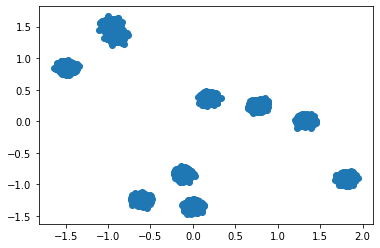

In [5]:
plt.scatter(X[:,0],X[:,1])

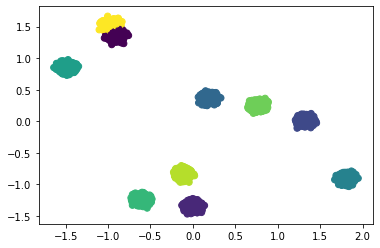

In [6]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=10).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:, 1], c=labels, s=40)

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

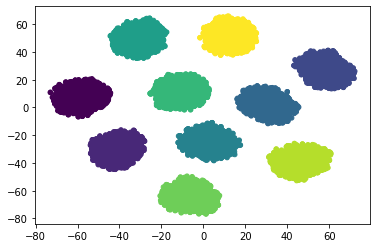

In [ ]:
plt.scatter(X_embedded[:,0], X_embedded[:, 1], c=labels, s=20)

In [7]:
from sklearn.utils.linear_assignment_ import linear_assignment
import numpy as np
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

from sklearn.metrics import confusion_matrix


def cluster_acc(predicted_labels,labels):
    cm = confusion_matrix(labels, predicted_labels)
    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    return np.trace(cm2)/np.sum(cm2),np.diag(cm2) / np.sum(cm2,0),cm2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [8]:
cluster_acc(labels,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


(0.9986, array([0.99005964, 0.99597586, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]), array([[ 996,    4,    0,    0,    0,    0,    0,    0,    0,    0],
        [  10,  990,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0, 1000,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0, 1000,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0, 1000,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0, 1000,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0, 1000,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1000]]))

Text(0.5, 1.0, 'Choose the number of clusters')

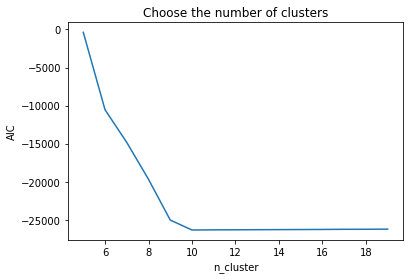

In [9]:
n_components = np.arange(5, 20, 1)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(X).aic(X) for model in models]
plt.plot(n_components, aics)
plt.xlabel("n_cluster")
plt.ylabel("AIC")
plt.title("Choose the number of clusters")

In [19]:
import numpy as np

m_true = np.array([[0, -2],[0, 0], [0, 2]])
covs_true = np.array([[[2, 0], [0, 0.2]], [[2, 0], [0, 0.2]], [[2, 0], [0, 0.2]]])
X = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 1000) for k in range(len(m_true))])
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [13]:
import numpy as np
a=[[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]]
b=np.array(a)+10
m_true=np.concatenate((np.array(a),b),0)
#m_true = np.array([[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]])
covs_true = np.array([[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]],[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]]])
X1 = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 1000) for k in range(len(m_true))])
# Standardize the data

In [14]:
import numpy as np
a=[[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]]
a=np.array(a)-3
b=a+10
m_true=np.concatenate((a,b),0)
#m_true = np.array([[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]])
covs_true = np.array([[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]],[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]]])
Y1 = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 1000) for k in range(len(m_true))])
# Standardize the data

In [15]:
import numpy as np
a=[[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]]
a=np.array(a)-10
b=a+10
m_true=np.concatenate((a,b),0)
#m_true = np.array([[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]])
covs_true = np.array([[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]],[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]]])
Y2 = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 1000) for k in range(len(m_true))])
# Standardize the data

In [16]:
import numpy as np
a=[[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]]
a=np.array(a)-4
b=a+10
m_true=np.concatenate((a,b),0)
#m_true = np.array([[0, 0], [3, -3], [3, 3], [-3, 3], [-3, -3]])
covs_true = np.array([[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]],[[0.5, 0], [0, 0.5]], [[0.5, 0.2], [0.2, 0.5]], [[0.5, -0.2], [-0.2, 0.5]], [[0.5, 0.2], [0.2, 0.5]],[[0.5, -0.2], [-0.2, 0.5]]])
Y3 = np.concatenate([np.random.multivariate_normal(m_true[k], covs_true[k], 1000) for k in range(len(m_true))])
# Standardize the data

In [17]:
X=np.concatenate((X1,Y1,Y2,Y3),1)
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [ ]:
type(X)

cupy.core.core.ndarray

In [ ]:

import numpy as np
with open('test.npy','rb') as f:
    y=np.load(f)
    o=np.load(f)
    X=np.load(f)

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X[:10000])

In [ ]:
X=X_transformed

In [20]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

-14241.894796221355
iteration 0
weights [0.03927014 0.0440021  0.05139799 0.0452029  0.1153992  0.03456003
 0.04984612 0.0401151  0.02832621 0.04406337 0.04853829 0.04000117
 0.04710042 0.03942304 0.06409914 0.04039842 0.02788282 0.06248536
 0.08102213 0.05686604]


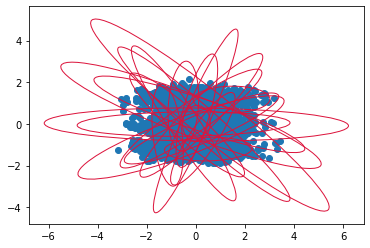

-12919.194240081479
-12388.456072471661
-12062.716554431947
-11743.00093626281
-11431.466334301369
-11122.461267172735
-10819.190154647367
-10534.834692861472
-10280.59243490729
-10054.548370680706
-9846.915680726754
-9649.585151285575
-9457.920527208413
-9269.38616655997
-9082.441880261174
-8895.9984967399
-8709.175618030706
-8521.193844948377
-8331.330903117612
-8138.917626130611
iteration 20
weights [0.01348639 0.00459841 0.01254479 0.00559043 0.30811456 0.00767659
 0.01008534 0.02075778 0.00779548 0.19837604 0.0032223  0.21137791
 0.02142166 0.01451695 0.01624453 0.00431203 0.02398013 0.01958384
 0.08033865 0.01597618]


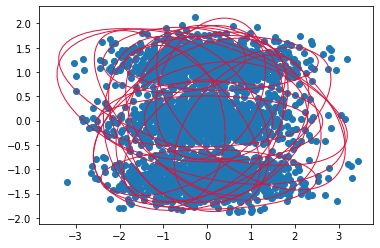

-7943.367026072387
-7744.241033991671
-7541.381511422137
-7335.177133445681
-7127.1040800940955
-6920.5650847642755
-6720.757354715559
-6531.442913959221
-6353.380502048081
-6182.906374919553
-6016.8326009002
-5855.211811075939
-5701.6999282187935
-5555.023399372973
-5409.61913449116
-5266.286211525672
-5124.874598490374
-4982.930318874595
-4842.493878500138
-4707.963075773747
iteration 40
weights [1.80429490e-03 3.94224603e-14 1.70401207e-05 3.94227551e-14
 3.26414689e-01 4.12181321e-14 5.94544268e-11 6.86493655e-03
 4.56519643e-14 3.08281622e-01 3.94224582e-14 2.48952686e-01
 9.61080144e-03 5.11717185e-04 1.56313794e-03 3.94224590e-14
 1.33677516e-02 4.81035803e-03 7.71599889e-02 6.40977368e-04]


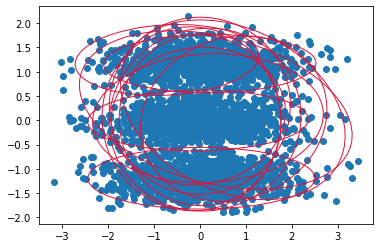

-4581.949408463288
-4467.153981104688
-4366.9400308896065
-4278.917796699704
-4201.372631862152
-4128.012400092051
-4054.638862802756
-3983.2775396968887
-3917.313403414076
-3857.6297296760154
-3802.1374928226164
-3752.530121729953
-3710.0131251647
-3672.082797709931
-3639.5732575517563
-3613.528611494189
-3590.404685826132
-3568.502446065043
-3549.4372006568915
-3535.8468266581726
iteration 60
weights [3.90501056e-14 3.90501056e-14 3.90501056e-14 3.90501056e-14
 3.30165886e-01 3.90501056e-14 3.90501056e-14 3.93542242e-14
 3.90501056e-14 3.36625096e-01 3.90501056e-14 2.68828568e-01
 8.93381907e-12 3.90501056e-14 3.90501056e-14 3.90501056e-14
 6.77902563e-05 3.90501168e-14 6.43126589e-02 3.90501056e-14]


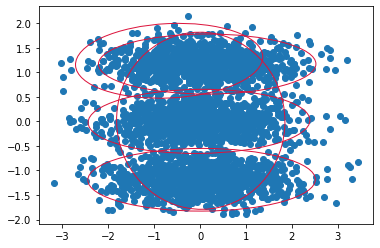

-3528.9173899945117
-3524.8805004986853
-3520.759765182538
-3516.4330258628625
-3511.947960544477
-3507.3075942726878
-3502.510843711859
-3497.555902881636
-3492.4406057490255
-3487.1625463628498
-3481.71914562741
-3476.107694561631
-3470.3253845193613
-3464.369329750055
-3458.2365854485183
-3451.924163212718
-3445.4290450939056
-3438.7481969735154
-3431.8785817241464
-3424.817172443359
iteration 80
weights [3.90110718e-14 3.90110718e-14 3.90110718e-14 3.90110718e-14
 3.30164557e-01 3.90110718e-14 3.90110718e-14 3.90110718e-14
 3.90110718e-14 3.36479435e-01 3.90110718e-14 2.85647067e-01
 3.90110718e-14 3.90110718e-14 3.90110718e-14 3.90110718e-14
 3.90110718e-14 3.90110718e-14 4.77089416e-02 3.90110718e-14]


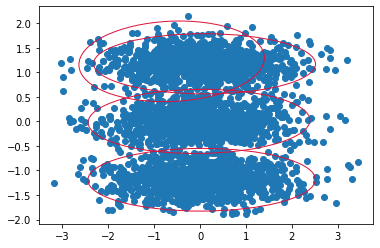

-3417.560965949181
-3410.1069966720092
-3402.4523510564863
-3394.594182588111
-3386.5297275813223
-3378.256321902592
-3369.7714188535197
-3361.072608500313
-3352.1576388045137
-3343.0244389771838
-3333.6711455369464
-3324.0961315864556
-3314.298039815283
-3304.275819669305
-3294.028768973384
-3283.556580035376
-3272.8593898773865
-3261.9378337319567
-3250.7931003210288
-3239.426986744647
iteration 100
weights [3.89769253e-14 3.89769253e-14 3.89769253e-14 3.89769253e-14
 3.30191895e-01 3.89769253e-14 3.89769253e-14 3.89769253e-14
 3.89769253e-14 3.35929386e-01 3.89769253e-14 3.04704025e-01
 3.89769253e-14 3.89769253e-14 3.89769253e-14 3.89769253e-14
 3.89769253e-14 3.89769253e-14 2.91746940e-02 3.89769253e-14]


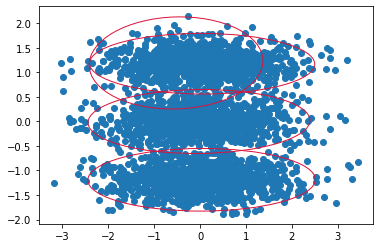

-3227.8419501145104
-3216.041152469462
-3204.0284951177528
-3191.8086384692238
-3179.3870037242677
-3166.7697534910058
-3153.963749444372
-3140.9764863783216
-3127.816003227987
-3114.4907726205843
-3101.0095710464266
-3087.3813316836145
-3073.614981234372
-3059.7192609246226
-3045.7025302919305
-3031.5725508472788
-3017.3362455306674
-3002.9994295215843
-2988.56650887516
-2974.0401460904104
iteration 120
weights [3.89713524e-14 3.89713524e-14 3.89713524e-14 3.89713524e-14
 3.30216134e-01 3.89713524e-14 3.89713524e-14 3.89713524e-14
 3.89713524e-14 3.35249080e-01 3.89713524e-14 3.23103563e-01
 3.89713524e-14 3.89713524e-14 3.89713524e-14 3.89713524e-14
 3.89713524e-14 3.89713524e-14 1.14312227e-02 3.89713524e-14]


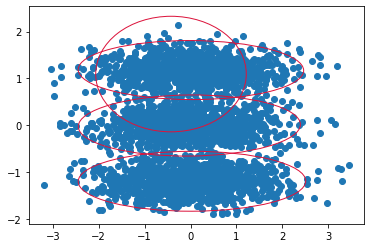

-2959.4208965184416
-2944.7068268748644
-2929.8931373796404
-2914.971822552132
-2899.931422958236
-2884.7569423733094
-2869.4300346693703
-2853.9296090615658
-2838.233077771118
-2822.318618380825
-2806.169154458831
-2789.779583219199
-2773.171025105692
-2756.422383639278
-2739.748652725144
-2723.705545857727
-2709.662632346438
-2700.2632012730796
-2697.2432833368193
-2697.196607126285
iteration 140
weights [3.90631594e-14 3.90631594e-14 3.90631594e-14 3.90631594e-14
 3.30218048e-01 3.90631594e-14 3.90631594e-14 3.90631594e-14
 3.90631594e-14 3.36271150e-01 3.90631594e-14 3.33510599e-01
 3.90631594e-14 3.90631594e-14 3.90631594e-14 3.90631594e-14
 3.90631594e-14 3.90631594e-14 2.01838032e-07 3.90631594e-14]


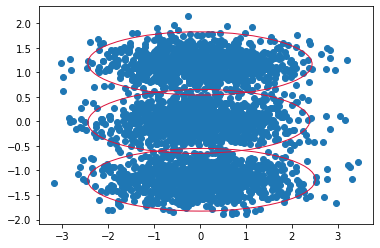

-2697.2251414907496
-2697.213424055127
-2697.2028377606425
-2697.1953993698767
-2697.1903397828387
-2697.186934960665
-2697.184656355267
-2697.183136643172
-2697.1821253600706
-2697.1814534414643
-2697.181007476409
-2697.1807116978994
-2697.180515627842
-2697.180385700001
-2697.180299623209
-2697.1802426073828
-2697.180204845581
-2697.1801798378733
-2697.1801632775155
-2697.1801523115246
iteration 160
weights [3.90640657e-14 3.90640657e-14 3.90640657e-14 3.90640657e-14
 3.30228474e-01 3.90640657e-14 3.90640657e-14 3.90640657e-14
 3.90640657e-14 3.36233912e-01 3.90640657e-14 3.33537614e-01
 3.90640657e-14 3.90640657e-14 3.90640657e-14 3.90640657e-14
 3.90640657e-14 3.90640657e-14 3.90640657e-14 3.90640657e-14]


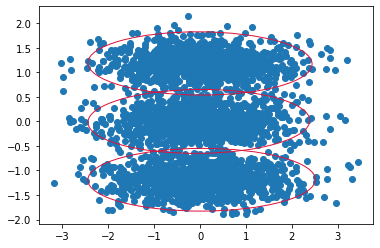

-2697.1801450502294
-2697.1801402421593
-2697.180137058523
-2697.1801349505167
-2697.1801335547416
-2697.18013263057
-2697.1801320186396
-2697.1801316134674
-2697.180131345187
-2697.1801311675576
-2697.1801310499563
-2697.1801309720863
-2697.1801309205216
-2697.1801308863814
-2697.180130863778
-2697.1801308488025
-2697.180130838899
-2697.180130832327
-2697.1801308279923
-2697.1801308251147
iteration 180
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


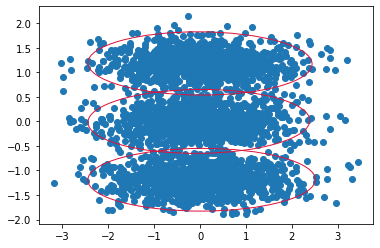

-2697.1801308232025
-2697.1801308219456
-2697.1801308211147
-2697.1801308205654
-2697.1801308201807
-2697.1801308199524
-2697.18013081979
-2697.1801308196914
-2697.180130819613
-2697.180130819566
-2697.1801308195345
-2697.1801308195077
-2697.180130819502
-2697.1801308194945
-2697.1801308194854
-2697.1801308194827
-2697.180130819482
-2697.180130819477
-2697.1801308194754
-2697.180130819473
iteration 200
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


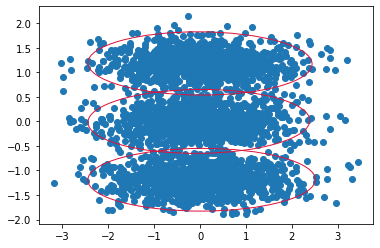

-2697.1801308194717
-2697.1801308194795
-2697.180130819472
-2697.1801308194717
-2697.1801308194686
-2697.1801308194686
-2697.1801308194695
-2697.180130819469
-2697.180130819475
-2697.180130819476
-2697.18013081947
-2697.1801308194713
-2697.180130819468
-2697.18013081947
-2697.1801308194713
-2697.18013081947
-2697.180130819475
-2697.180130819472
-2697.1801308194713
-2697.18013081947
iteration 220
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


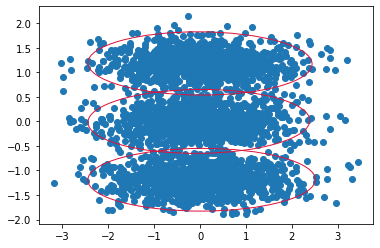

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 240
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


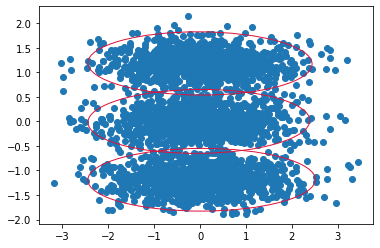

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 260
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


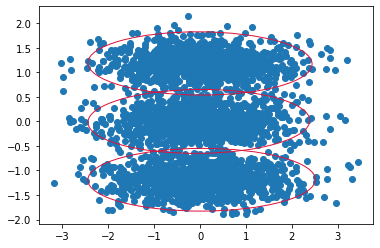

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 280
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


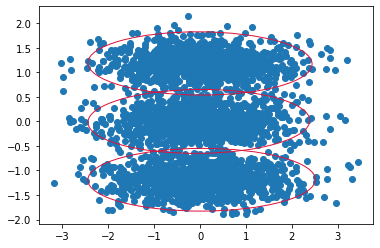

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 300
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


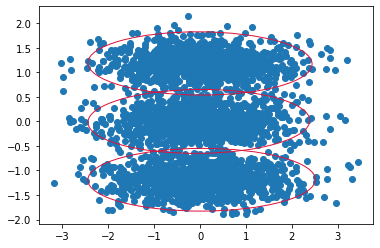

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 320
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


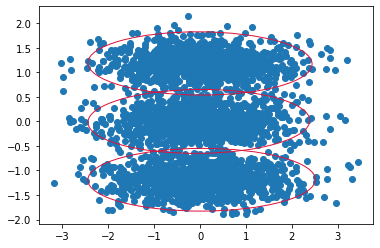

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 340
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


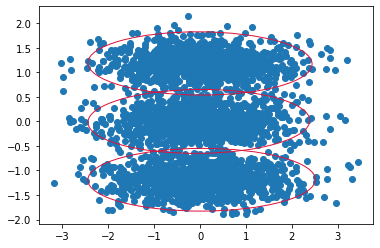

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 360
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


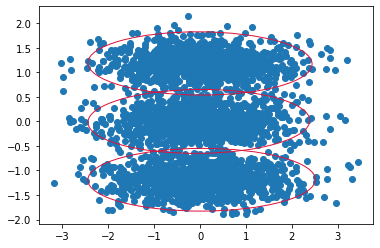

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 380
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


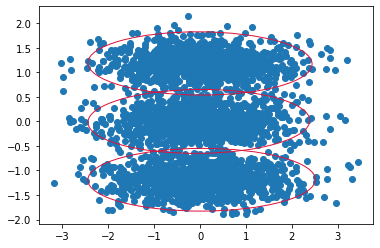

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 400
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


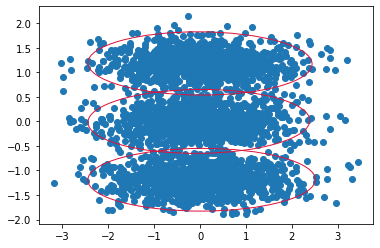

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 420
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


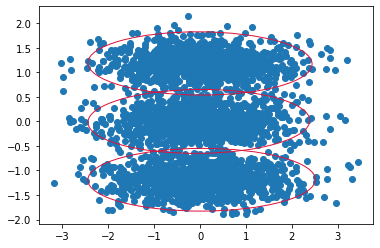

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 440
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


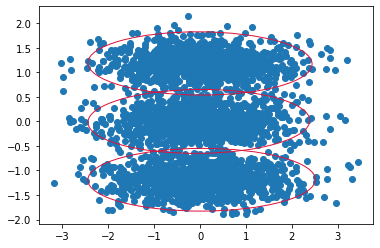

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 460
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


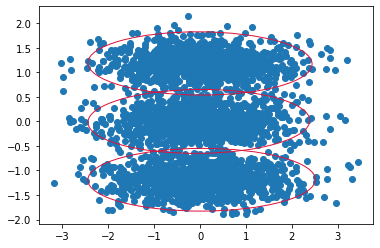

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 480
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


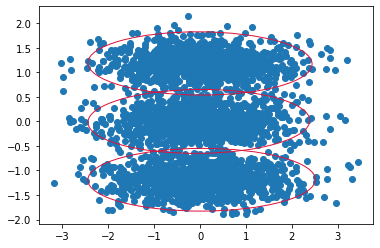

-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
-2697.1801308194763
-2697.1801308194713
-2697.1801308194713
-2697.18013081947
iteration 500
weights [3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.30228478e-01 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.36233901e-01 3.90640663e-14 3.33537620e-01
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14
 3.90640663e-14 3.90640663e-14 3.90640663e-14 3.90640663e-14]


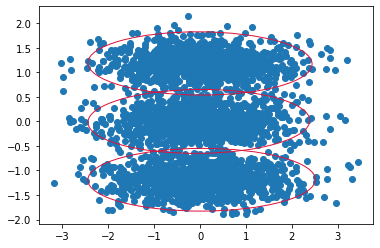

In [21]:

start=time.time()
model = VariationalGaussianMixture(K=20,max_iter=501,init_param="kmeans")
model.fit(X)
end=time.time()



In [22]:
end-start#time

34.88254475593567

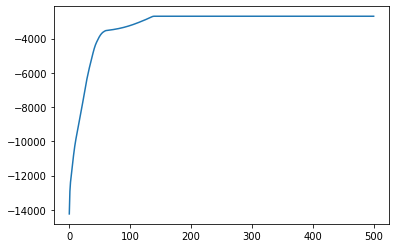

In [24]:
plt.plot(range(len(model.elbo)),cp.asnumpy(model.elbo))



In [25]:
mean=model.m[model.weights>1e-5]

In [26]:
cov=model.covs[model.weights>1e-5]

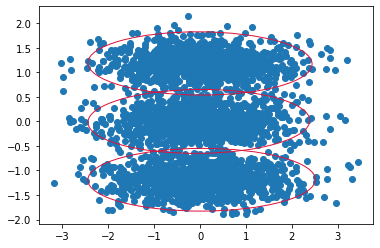

In [28]:

plt.figure()
ax = plt.gca()
for i in range(mean.shape[0]):
    plot_confidence_ellipse(cp.asnumpy(mean[i]), cp.asnumpy(cov[i]), 0.95, ax, ec='crimson')
ax.scatter(X[:,0],X[:,1])
plt.show()